In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import sys, os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import easydict
from meta_neural_network_architectures import VGGReLUNormNetwork, ResNet12
from utils.parser_utils import get_args
from data import MetaLearningSystemDataLoader
from experiment_builder import ExperimentBuilder

from few_shot_learning_system import MAMLFewShotClassifier
from utils import loss_landscape

# 1. 모델 설정하기

## 1-1) MAML Model 불러오기

In [3]:
os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
print("os.environ['DATASET_DIR'] === ", os.environ['DATASET_DIR'])

args_maml = easydict.EasyDict(
{
  "batch_size":2,
  "image_height":84,
  "image_width":84,
  "image_channels":3,
  "gpu_to_use":0,
  "num_dataprovider_workers":4,
  "max_models_to_save":5,
  "dataset_name":"mini_imagenet_full_size",
  "dataset_path":"mini_imagenet_full_size",
  "reset_stored_paths":False,
  "experiment_name":"../MAML_filter64",
  "train_seed": 0, "val_seed": 0,
  "indexes_of_folders_indicating_class": [-3, -2],
  "sets_are_pre_split": True,
  "train_val_test_split": [0.64, 0.16, 0.20],
  "evaluate_on_test_set_only": False,

  "total_epochs": 100,
  "total_iter_per_epoch":500, "continue_from_epoch": -2,
  "num_evaluation_tasks":600,
  "multi_step_loss_num_epochs": 15,
  "minimum_per_task_contribution": 0.01,
  "learnable_per_layer_per_step_inner_loop_learning_rate": False,
  "enable_inner_loop_optimizable_bn_params": False,
  "evalute_on_test_set_only": False,

  "max_pooling": True,
  "per_step_bn_statistics": False,
  "learnable_batch_norm_momentum": False,
  "load_into_memory": False,
  "init_inner_loop_learning_rate": 0.01,
  "init_inner_loop_weight_decay": 0.0005,
  "learnable_bn_gamma": True,
  "learnable_bn_beta": True,

  "dropout_rate_value":0.0,
  "min_learning_rate":0.001,
  "meta_learning_rate":0.001,   "total_epochs_before_pause": 100,
  "first_order_to_second_order_epoch":-1,
  "weight_decay": 0.0,

  "norm_layer":"batch_norm",
  "cnn_num_filters":64,
  "num_stages":4,
  "conv_padding": True,
  "number_of_training_steps_per_iter":5,
  "number_of_evaluation_steps_per_iter":5,
  "cnn_blocks_per_stage":1,
  "num_classes_per_set":5,
  "num_samples_per_class":5,
  "num_target_samples": 15,
  "samples_per_iter" : 1,

  "second_order": True,
  "use_multi_step_loss_optimization":False,
  "backbone": "4-CONV",
  "arbiter": False,
  "use_bias": True,
  "smoothing": False,
  "knowledge_distillation": False
}
)

device = torch.cuda.current_device()
args_maml.im_shape = (2, 3, args_maml.image_height, args_maml.image_width)

args_maml.use_cuda = torch.cuda.is_available()
args_maml.seed = 104
args_maml.reverse_channels=False
args_maml.labels_as_int=False
args_maml.reset_stored_filepaths=False
args_maml.num_of_gpus=1

args_maml.continue_from_epoch='latest'

os.environ['DATASET_DIR'] ===  C:/Users/JM/PycharmProjects/MAML/datasets


## 1-2) Arbiter Model 불러오기

In [4]:
os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
print("os.environ['DATASET_DIR'] === ", os.environ['DATASET_DIR'])

args_arbiter = easydict.EasyDict(
{
  "batch_size":2,
  "image_height":84,
  "image_width":84,
  "image_channels":3,
  "gpu_to_use":0,
  "num_dataprovider_workers":4,
  "max_models_to_save":5,
  "dataset_name":"mini_imagenet_full_size",
  "dataset_path":"mini_imagenet_full_size",
  "reset_stored_paths":False,
  "experiment_name":"../MAML+Arbiter_5way_5shot",
  "train_seed": 0, "val_seed": 0,
  "indexes_of_folders_indicating_class": [-3, -2],
  "sets_are_pre_split": True,
  "train_val_test_split": [0.64, 0.16, 0.20],
  "evaluate_on_test_set_only": False,

  "total_epochs": 150,
  "total_iter_per_epoch":500, "continue_from_epoch": -2,
  "num_evaluation_tasks":600,
  "multi_step_loss_num_epochs": 15,
  "minimum_per_task_contribution": 0.01,
  "learnable_per_layer_per_step_inner_loop_learning_rate": False,
  "enable_inner_loop_optimizable_bn_params": False,
  "evalute_on_test_set_only": False,

  "max_pooling": True,
  "per_step_bn_statistics": False,
  "learnable_batch_norm_momentum": False,
  "load_into_memory": False,
  "init_inner_loop_learning_rate": 0.01,
  "init_inner_loop_weight_decay": 0.0005,
  "learnable_bn_gamma": True,
  "learnable_bn_beta": True,

  "dropout_rate_value":0.0,
  "min_learning_rate":0.001,
  "meta_learning_rate":0.001,   "total_epochs_before_pause": 100,
  "first_order_to_second_order_epoch":-1,
  "weight_decay": 0.0,

  "norm_layer":"batch_norm",
  "cnn_num_filters":128,
  "num_stages":4,
  "conv_padding": True,
  "number_of_training_steps_per_iter":5,
  "number_of_evaluation_steps_per_iter":5,
  "cnn_blocks_per_stage":1,
  "num_classes_per_set":5,
  "num_samples_per_class":5,
  "num_target_samples": 15,
  "samples_per_iter" : 1,

  "second_order": True,
  "use_multi_step_loss_optimization":False,
  "backbone": "4-CONV",
  "arbiter": True,
  "use_bias": True,
  "smoothing": False,
  "knowledge_distillation": False
}
)

device = torch.cuda.current_device()
args_arbiter.im_shape = (2, 3, args_arbiter.image_height, args_arbiter.image_width)

args_arbiter.use_cuda = torch.cuda.is_available()
args_arbiter.seed = 104
args_arbiter.reverse_channels=False
args_arbiter.labels_as_int=False
args_arbiter.reset_stored_filepaths=False
args_arbiter.num_of_gpus=1

args_arbiter.continue_from_epoch='latest'

os.environ['DATASET_DIR'] ===  C:/Users/JM/PycharmProjects/MAML/datasets


# 2. Model 구성 및 상태 확인

## 2-1) MAML 모델 구성하기 

In [5]:
# 모델을 구성한다
model_maml = MAMLFewShotClassifier(args=args_maml, device=device,
                              im_shape=(2, 3,
                                        args_maml.image_height, args_maml.image_width))

data = MetaLearningSystemDataLoader

maml_system = ExperimentBuilder(model=model_maml, data=data, args=args_maml, device=device)

# maml_system.state


model_save_dir = maml_system.saved_models_filepath
model_name = "train_model"
model_idx = maml_system.state['best_epoch']

state = maml_system.model.load_model(model_save_dir=model_save_dir,
                                     model_name=model_name,
                                     model_idx=model_idx)

state_dict_loaded = state['network']

maml_system.model.load_state_dict(state_dict=state_dict_loaded)

# # 잘 불러왔는지 확인하는 코드
# print("state_dict_loaded == ",state_dict_loaded)
# print("="*10)
# for key, value in maml_system.model.named_parameters():
#     print(key)
#     print(value)

Using max pooling
No inner loop params
torch.Size([2, 64, 84, 84])
No inner loop params
No inner loop params
torch.Size([2, 64, 42, 42])
No inner loop params
No inner loop params
torch.Size([2, 64, 21, 21])
No inner loop params
No inner loop params
torch.Size([2, 64, 10, 10])
No inner loop params
(VGGReLUNormNetwork) meta network params
layer_dict.conv0.conv.weight torch.Size([64, 3, 3, 3])
layer_dict.conv0.conv.bias torch.Size([64])
layer_dict.conv0.norm_layer.running_mean torch.Size([64])
layer_dict.conv0.norm_layer.running_var torch.Size([64])
layer_dict.conv0.norm_layer.bias torch.Size([64])
layer_dict.conv0.norm_layer.weight torch.Size([64])
layer_dict.conv1.conv.weight torch.Size([64, 64, 3, 3])
layer_dict.conv1.conv.bias torch.Size([64])
layer_dict.conv1.norm_layer.running_mean torch.Size([64])
layer_dict.conv1.norm_layer.running_var torch.Size([64])
layer_dict.conv1.norm_layer.bias torch.Size([64])
layer_dict.conv1.norm_layer.weight torch.Size([64])
layer_dict.conv2.conv.weight

<All keys matched successfully>

## 2-2) Arbiter 모델 구성하기

In [6]:
# 모델을 구성한다
model_arbiter = MAMLFewShotClassifier(args=args_arbiter, device=device,
                              im_shape=(2, 3,
                                        args_arbiter.image_height, args_arbiter.image_width))

data = MetaLearningSystemDataLoader

arbiter_system = ExperimentBuilder(model=model_arbiter, data=data, args=args_arbiter, device=device)

arbiter_system.state

model_save_dir = arbiter_system.saved_models_filepath
model_name = "train_model"
model_idx = arbiter_system.state['best_epoch']

state = arbiter_system.model.load_model(model_save_dir=model_save_dir,
                                     model_name=model_name,
                                     model_idx=model_idx)

state_dict_loaded = state['network']

arbiter_system.model.load_state_dict(state_dict=state_dict_loaded)

# 잘 불러왔는지 확인하는 코드
print("state_dict_loaded == ",state_dict_loaded)
print("="*10)
for key, value in arbiter_system.model.named_parameters():
    print(key)
    print(value)

Using max pooling
No inner loop params
torch.Size([2, 128, 84, 84])
No inner loop params
No inner loop params
torch.Size([2, 128, 42, 42])
No inner loop params
No inner loop params
torch.Size([2, 128, 21, 21])
No inner loop params
No inner loop params
torch.Size([2, 128, 10, 10])
No inner loop params
(VGGReLUNormNetwork) meta network params
layer_dict.conv0.conv.weight torch.Size([128, 3, 3, 3])
layer_dict.conv0.conv.bias torch.Size([128])
layer_dict.conv0.norm_layer.running_mean torch.Size([128])
layer_dict.conv0.norm_layer.running_var torch.Size([128])
layer_dict.conv0.norm_layer.bias torch.Size([128])
layer_dict.conv0.norm_layer.weight torch.Size([128])
layer_dict.conv1.conv.weight torch.Size([128, 128, 3, 3])
layer_dict.conv1.conv.bias torch.Size([128])
layer_dict.conv1.norm_layer.running_mean torch.Size([128])
layer_dict.conv1.norm_layer.running_var torch.Size([128])
layer_dict.conv1.norm_layer.bias torch.Size([128])
layer_dict.conv1.norm_layer.weight torch.Size([128])
layer_dict.

Parameter containing:
tensor([-0.2753, -0.2707, -0.2466, -0.2910, -0.2711, -0.2788, -0.2589, -0.2447,
        -0.2656, -0.2997, -0.2979, -0.3034, -0.3116, -0.3134, -0.3431, -0.2695,
        -0.2478, -0.2443, -0.3024, -0.2146, -0.2261, -0.4464, -0.2575, -0.3249,
        -0.2227, -0.3362, -0.2887, -0.4103, -0.3027, -0.3060, -0.3619, -0.3881,
        -0.3583, -0.3188, -0.4115, -0.3289, -0.3245, -0.3787, -0.2633, -0.3451,
        -0.2412, -0.3514, -0.2272, -0.2664, -0.1843, -0.3301, -0.2738, -0.3602,
        -0.2992, -0.2726, -0.2881, -0.3350, -0.3114, -0.3082, -0.3098, -0.2928,
        -0.3099, -0.2795, -0.2872, -0.2829, -0.4139, -0.4311, -0.2442, -0.3044,
        -0.3380, -0.2921, -0.2908, -0.2631, -0.2046, -0.2382, -0.3054, -0.2646,
        -0.3268, -0.1979, -0.2440, -0.3629, -0.2186, -0.2627, -0.3118, -0.2368,
        -0.2886, -0.4221, -0.2613, -0.3040, -0.2617, -0.2238, -0.2637, -0.3133,
        -0.2974, -0.3393, -0.2234, -0.3133, -0.2493, -0.4253, -0.2305, -0.2312,
        -0.2592, -

## 3. 가중치 분포 그리기

## 3-1) MAML

In [15]:
maml_conv3 = maml_system.model.classifier.layer_dict.conv3.conv.weight

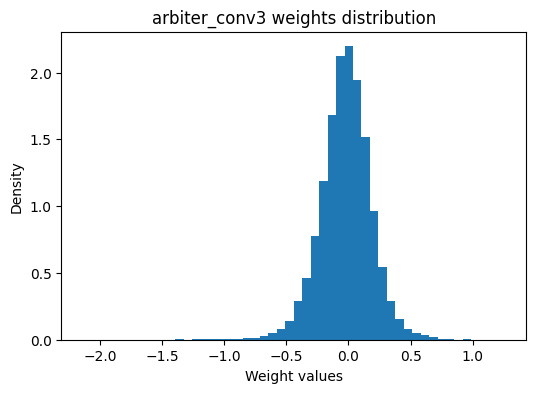

In [16]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

maml_conv3 = maml_conv3.data.cpu().numpy()

# 가중치 분포 그리기
plt.figure(figsize=(6, 4))
plt.hist(maml_conv3.flatten(), bins=50, density=True) # density와 frequency의 차이가 뭐지?
plt.title('arbiter_conv3 weights distribution')
plt.xlabel('Weight values')
plt.ylabel('Density')
plt.show()

## 3-2) Arbiter

In [13]:
arbiter_conv3 = arbiter_system.model.classifier.layer_dict.conv3.conv.weight

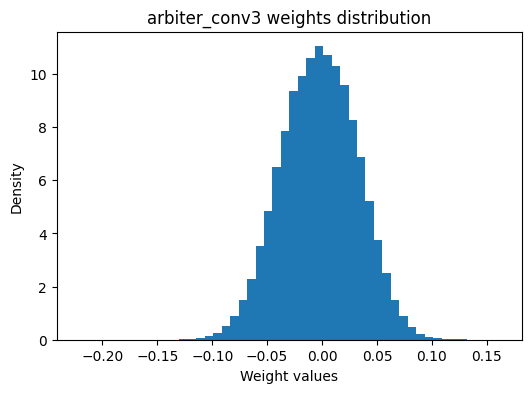

In [14]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

arbiter_conv3 = arbiter_conv3.data.cpu().numpy()


# 가중치 분포 그리기
plt.figure(figsize=(6, 4))
plt.hist(arbiter_conv3.flatten(), bins=50, density=True) # density와 frequency의 차이가 뭐지?
plt.title('arbiter_conv3 weights distribution')
plt.xlabel('Weight values')
plt.ylabel('Density')
plt.show()

## 3-3) MAML과 Arbiter 함께 그리기

### Conv1

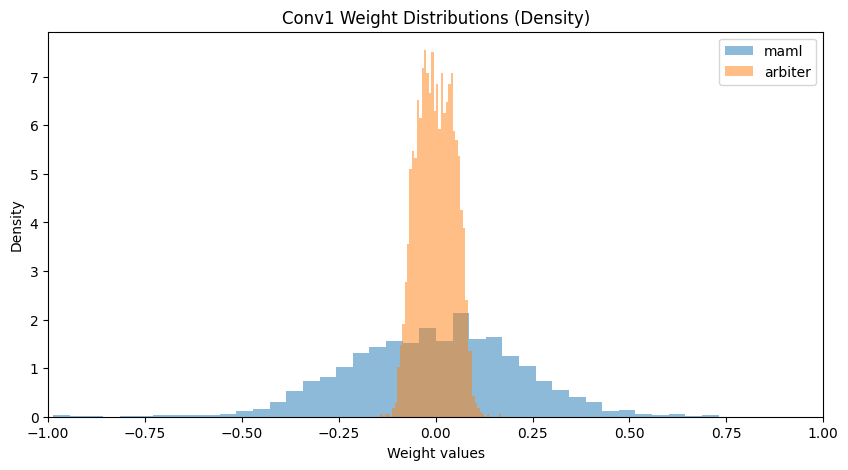

In [53]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 특정 레이어의 가중치 가져오기
maml_conv3 = maml_system.model.classifier.layer_dict.conv0.conv.weight.data.cpu().numpy().flatten()
arbiter_conv3 = arbiter_system.model.classifier.layer_dict.conv0.conv.weight.data.cpu().numpy().flatten()

# 가중치 분포 그리기
plt.figure(figsize=(10, 5))
plt.hist(maml_conv3, bins=50, alpha=0.5, label='maml', density=True)
plt.hist(arbiter_conv3, bins=50, alpha=0.5, label='arbiter', density=True)

plt.title('Conv1 Weight Distributions (Density)')
plt.xlabel('Weight values')
plt.ylabel('Density')
plt.legend(loc='upper right')

plt.xlim([-1.0, 1.0])

plt.show()

### Conv2

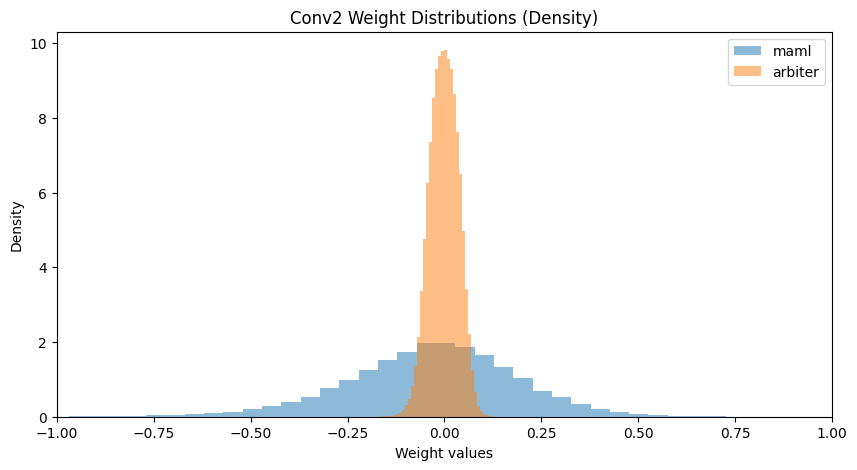

In [46]:
# 특정 레이어의 가중치 가져오기
maml_conv3 = maml_system.model.classifier.layer_dict.conv1.conv.weight.data.cpu().numpy().flatten()
arbiter_conv3 = arbiter_system.model.classifier.layer_dict.conv1.conv.weight.data.cpu().numpy().flatten()

# 가중치 분포 그리기
plt.figure(figsize=(10, 5))
plt.hist(maml_conv3, bins=50, alpha=0.5, label='maml', density=True)
plt.hist(arbiter_conv3, bins=50, alpha=0.5, label='arbiter', density=True)

plt.title('Conv2 Weight Distributions (Density)')
plt.xlabel('Weight values')
plt.ylabel('Density')
plt.legend(loc='upper right')

plt.xlim([-1.0, 1.0])

plt.show()

### Conv3

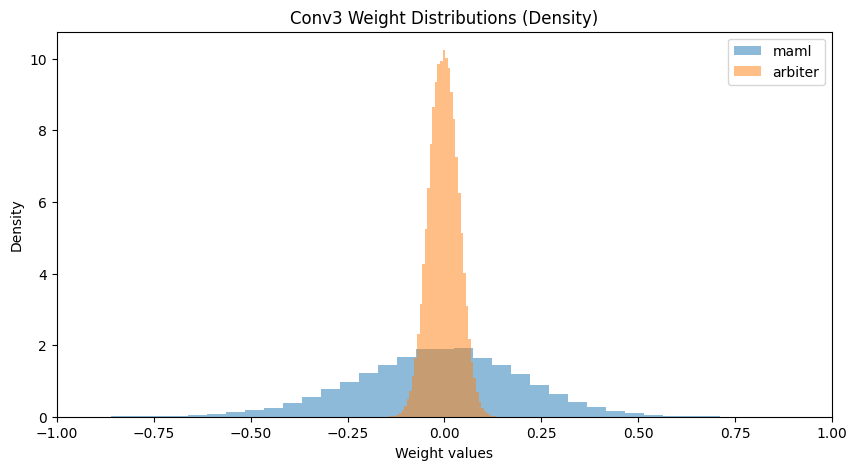

In [47]:
# 특정 레이어의 가중치 가져오기
maml_conv2 = maml_system.model.classifier.layer_dict.conv2.conv.weight.data.cpu().numpy().flatten()
arbiter_conv2 = arbiter_system.model.classifier.layer_dict.conv2.conv.weight.data.cpu().numpy().flatten()

# 가중치 분포 그리기
plt.figure(figsize=(10, 5))
plt.hist(maml_conv2, bins=50, alpha=0.5, label='maml', density=True)
plt.hist(arbiter_conv2, bins=50, alpha=0.5, label='arbiter', density=True)

plt.title('Conv3 Weight Distributions (Density)')
plt.xlabel('Weight values')
plt.ylabel('Density')
plt.legend(loc='upper right')

plt.xlim([-1.0, 1.0])

plt.show()

### Conv4

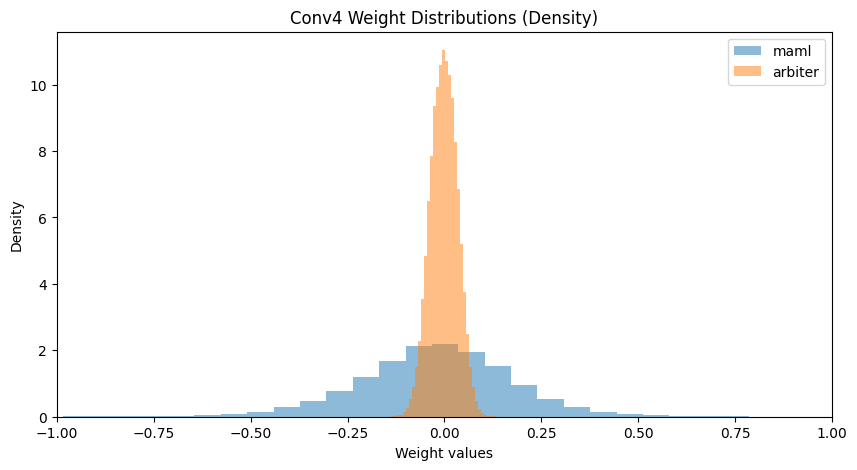

In [44]:
# 특정 레이어의 가중치 가져오기
maml_conv3 = maml_system.model.classifier.layer_dict.conv3.conv.weight.data.cpu().numpy().flatten()
arbiter_conv3 = arbiter_system.model.classifier.layer_dict.conv3.conv.weight.data.cpu().numpy().flatten()

# 가중치 분포 그리기
plt.figure(figsize=(10, 5))
plt.hist(maml_conv3, bins=50, alpha=0.5, label='maml', density=True)
plt.hist(arbiter_conv3, bins=50, alpha=0.5, label='arbiter', density=True)

plt.title('Conv4 Weight Distributions (Density)')
plt.xlabel('Weight values')
plt.ylabel('Density')
plt.legend(loc='upper right')

plt.xlim([-1.0, 1.0])

plt.show()

### Linear Layer

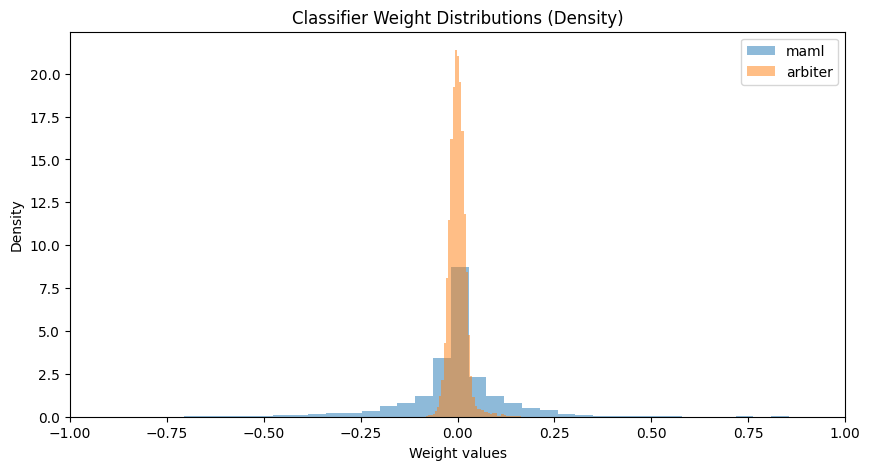

In [52]:
# 특정 레이어의 가중치 가져오기
maml_conv3 = maml_system.model.classifier.layer_dict.linear.weights.data.cpu().numpy().flatten()
arbiter_conv3 = arbiter_system.model.classifier.layer_dict.linear.weights.data.cpu().numpy().flatten()

# 가중치 분포 그리기
plt.figure(figsize=(10, 5))
plt.hist(maml_conv3, bins=50, alpha=0.5, label='maml', density=True)
plt.hist(arbiter_conv3, bins=50, alpha=0.5, label='arbiter', density=True)

plt.title('Classifier Weight Distributions (Density)')
plt.xlabel('Weight values')
plt.ylabel('Density')
plt.legend(loc='upper right')

plt.xlim([-1.0, 1.0])

plt.show()